In [5]:
import sys, qiskit
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np, os, json
import qiskit.quantum_info as qi
import pandas as pd
%load_ext autoreload
%autoreload 2

<img src = '../docs/compilation-design1.png' height ='500px'>
<img src = '../docs/compilation-design2.png' height ='500px'>

### Drawing

In [2]:
df = pd.read_csv('risk.csv')
# draw risk curve and cost curve for each depth with same n, n_circuit and n_gen
n = 3
n_circuit = 4  # replace with your actual value
n_gen = 10  # replace with your actual value
for n_gen in [10]:
    # Filter the data
    df_filtered = df[(df['n'] == n) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
    # Sort the data by 'd' (depth)
    df_filtered = df_filtered.sort_values('d')
    # labeling each point by depth value
    for i, d in enumerate(df_filtered['d']):
        plt.annotate(d, (df_filtered['cost'].iloc[i], df_filtered['risk'].iloc[i] + 0.1))
    plt.plot(df_filtered['cost'], df_filtered['risk'], label=f'Risk by depth with n_gen = {n_gen}', marker = 'o', color = 'b')
# legend for annotate points
plt.scatter([], [], label='Depth', c='blue')
plt.xlabel('Cost')
plt.ylabel('Risk')
plt.ylim(-1, 1)
plt.title(f'Risk Curve for n={n}, n_circuit={n_circuit}, n_gen={n_gen}')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'risk.csv'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


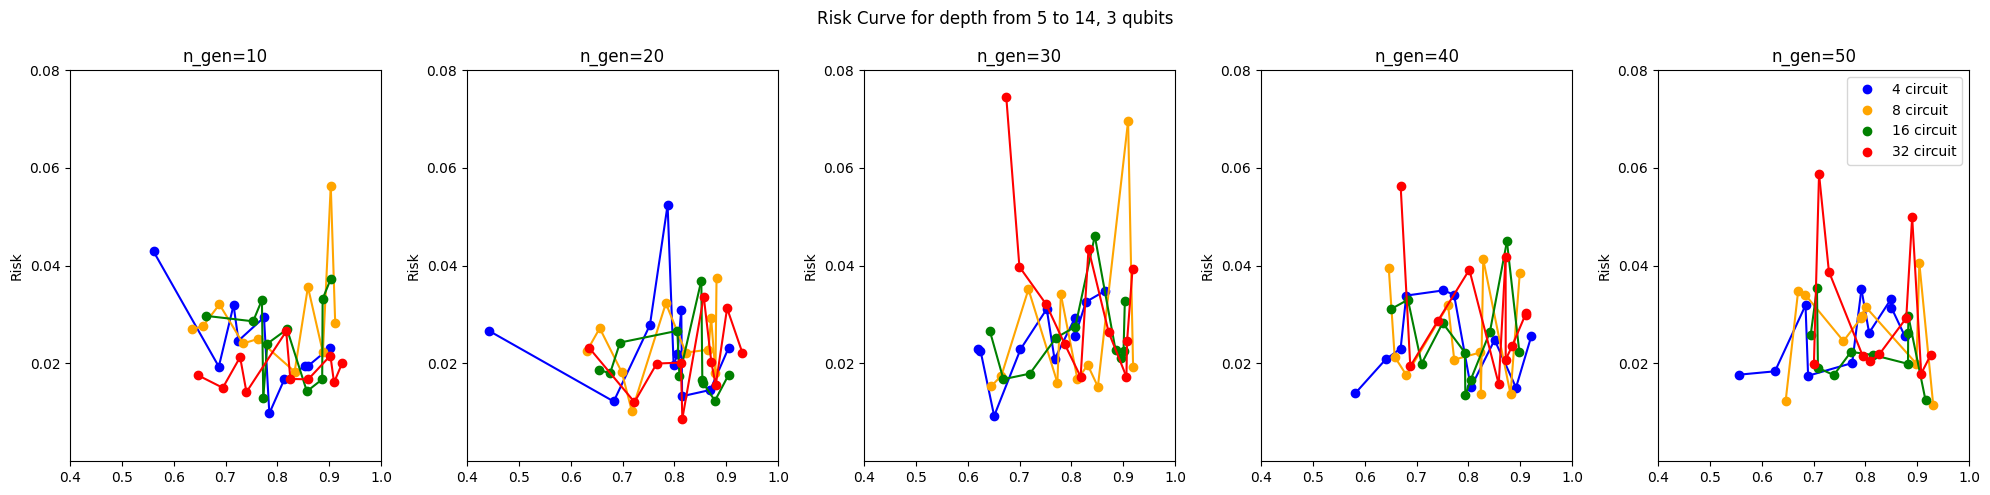

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

def indices_for_sorted_order(data_list):
    # Enumerate the list and then sort by the elements, keeping track of the original indices
    sorted_indices = [index for index, value in sorted(enumerate(data_list), key=lambda x: x[1])]
    return sorted_indices

def sort_by_indices(data_list, index_list):
    # Ensure the index list is the same length as the data list
    if len(data_list) != len(index_list):
        raise ValueError("Length of index_list must be the same as length of data_list")

    # Sort the data_list according to the index_list
    sorted_list = [data_list[i] for i in index_list]
    return sorted_list

n = 3
# Load the data
df = pd.read_csv('cost.csv')  # replace with your actual file path

# Filter the data for n = 3
df_filtered = df[df['n'] == n]

# Group by n_circuit, n_gen, and d, and calculate the mean of risk and cost
grouped = df_filtered.groupby(['n_circuit', 'n_gen', 'd'])['cost'].mean().reset_index()

# Get the unique values of n_circuit and n_gen
n_circuit_values = grouped['n_circuit'].unique()
n_gen_values = grouped['n_gen'].unique()

# Plot the average risk and cost curves for each n_circuit and n_gen
fig, axs = plt.subplots(1, len(n_gen_values), figsize=(20, 5))

colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, n_circuit in enumerate(n_circuit_values):
    
    for j, n_gen in enumerate(n_gen_values):
        # Plot cost
        axs[j].set_title(f'n_gen={n_gen}')
        data = grouped[(grouped['n_circuit'] == n_circuit) & (grouped['n_gen'] == n_gen)]
        # axs[i, j].plot(data['cost'], [0]*(len(data['cost'])), label='1-Cost', linestyle = '', marker = 'o')
        
        risks = []
        # Plot risk
        for d in range(5,15):
            # read value by key json
            with open(f'risk_{n}.json') as f:
                risk_data = json.load(f)
            risk = risk_data[f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}']
            risks.append(risk)
        x = list((data['cost'] ))
        y = list(np.mean(risks, 1))
        y = sort_by_indices(y, indices_for_sorted_order(x))
        x = sorted(x)
        for k in range(0, len(x) - 1):
            axs[j].plot([x[k],x[k + 1]], [y[k], y[k+1]], color=colors[i])
        axs[j].plot(x, y, label=f'{n_circuit} circuit', linestyle='', marker = 'o', color = colors[i])
        axs[j].set_ylim(0, 0.08)
        axs[j].set_yticks([0.02, 0.04, 0.06, 0.08])
        axs[j].set_xlim(0.4, 1)
        #axs[i, j].fill_between(data['cost'], np.asarray(y) + np.asarray(yvar), np.asarray(y) - np.asarray(yvar), alpha = 0.2, color='r')
        # axs[i, j].legend()
        # axs[i, j].set_xlabel('1 - Cost')
        axs[j].set_ylabel('Risk')
        # for k in range(0, len(x)):
        #     axs[i,j].plot([x[k],x[k]], [0,y[k]], color='black')
        # axs[j].set_yscale('log')
plt.legend()
fig.suptitle(f'Risk Curve for depth from 5 to 14, 3 qubits')
plt.tight_layout()
plt.savefig('../images/risk_curve2.eps', format='eps')
plt.show()

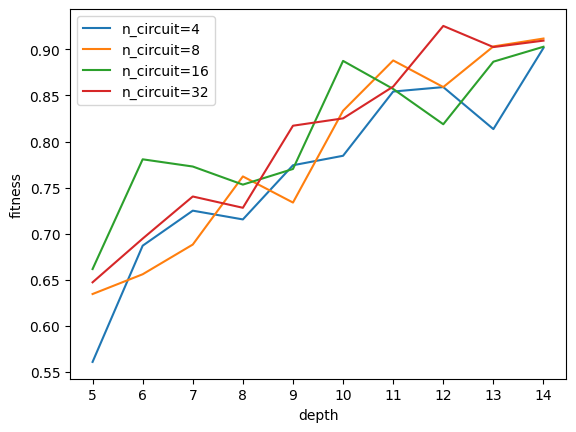

In [21]:
num_qubits = 3
num_circuit = 4
num_generation = 10
depths = range(5, 15)
# qubit = 2, depth = 4
# qubit = 3, depth around 15
# qubit = 4, depth around 40
# qubit = 5, depth around 100
# num_generation = 10, 20, 30, ...
# num_circuit = 4, 8, 16, 32, ...
# depth = 2,3,4, ...

# read all files metadata.json inside list of folders

for num_circuit in [4, 8, 16, 32]:
    best_fitness = []
    for depth in depths:
        envx = EEnvironment.load(f'n={num_qubits},d={depth},n_circuit={num_circuit},n_gen={num_generation}', None)
        best_fitness.append(np.max(envx.metadata.best_fitnesss))
    plt.plot(best_fitness, label=f'n_circuit={num_circuit}')
    
plt.ylabel('fitness')
plt.xlabel('depth')
plt.xticks(range(len(depths)), depths)
plt.legend()

### Update cost column from folders

In [12]:
import pandas as pd

# Define the column names
columns = ['n', 'd', 'n_circuit', 'n_gen', 'cost']

# Create an empty DataFrame with the column names
df = pd.DataFrame(columns=columns)
ns = [2, 3, 4, 5]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]


# Append the lists of values as new rows to the DataFrame
for n in ns:
    for num_circuit in num_circuits:
        for num_generation in num_generations:
            if n == 2:
                depths = list(range(2, 10))
            elif n == 3:
                depths = list(range(2, 15))
            elif n == 4:
                depths = list(range(2, 30))
            elif n == 5:
                depths = list(range(2, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for depth in depths:
                df.loc[len(df)] = [n, depth, num_circuit, num_generation, 0]
df.to_csv('cost.csv', index=False)

In [14]:
# create an empty csv file has columns: n,depth,n_circuit,n_gen,risk
# n = 2,3,4,5,6
# depth = 2,3,4, ...
# n_circuit = 4,8,16,32, ...
# n_gen = 10,20,30, ...
# risk = 0.1,0.2,0.3, ...

def changeCost(n, d, n_circuit, n_gen, cost):
    df = pd.read_csv('cost.csv')
    filtered_df = df[(df['n'] == n) & (df['d'] == d) & (df['n_circuit'] == n_circuit) & (df['n_gen'] == n_gen)]
    row_index = filtered_df.index.tolist()[0]
    if df.loc[row_index]['cost'] == 0:
        df.loc[row_index] = [n, d, n_circuit, n_gen, cost]
        df.to_csv('cost.csv', index=False)
    return

import pandas as pd
import csv

ns = [2, 3, 4, 5]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 10))
            elif n == 3:
                depths = list(range(2, 15))
            elif n == 4:
                depths = list(range(2, 30))
            elif n == 5:
                depths = list(range(2, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'../data/n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')
                    from qoop.evolution.environment import EEnvironment
                    envx = EEnvironment.load(f'../data/n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
                    best_fitness = (np.max(envx.metadata.best_fitnesss))
                    changeCost(n, d, n_circuit, n_gen, best_fitness)


n=2,d=2,n_circuit=4,n_gen=10
n=2,d=3,n_circuit=4,n_gen=10
n=2,d=4,n_circuit=4,n_gen=10
n=2,d=5,n_circuit=4,n_gen=10
n=2,d=2,n_circuit=4,n_gen=20
n=2,d=3,n_circuit=4,n_gen=20
n=2,d=4,n_circuit=4,n_gen=20
n=2,d=5,n_circuit=4,n_gen=20
n=2,d=2,n_circuit=4,n_gen=30
n=2,d=3,n_circuit=4,n_gen=30
n=2,d=4,n_circuit=4,n_gen=30
n=2,d=5,n_circuit=4,n_gen=30
n=2,d=2,n_circuit=4,n_gen=40
n=2,d=3,n_circuit=4,n_gen=40
n=2,d=4,n_circuit=4,n_gen=40
n=2,d=5,n_circuit=4,n_gen=40
n=2,d=2,n_circuit=4,n_gen=50
n=2,d=3,n_circuit=4,n_gen=50
n=2,d=4,n_circuit=4,n_gen=50
n=2,d=5,n_circuit=4,n_gen=50
n=2,d=2,n_circuit=8,n_gen=10
n=2,d=3,n_circuit=8,n_gen=10
n=2,d=4,n_circuit=8,n_gen=10
n=2,d=5,n_circuit=8,n_gen=10
n=2,d=2,n_circuit=8,n_gen=20
n=2,d=3,n_circuit=8,n_gen=20
n=2,d=4,n_circuit=8,n_gen=20
n=2,d=5,n_circuit=8,n_gen=20
n=2,d=2,n_circuit=8,n_gen=30
n=2,d=3,n_circuit=8,n_gen=30
n=2,d=4,n_circuit=8,n_gen=30
n=2,d=5,n_circuit=8,n_gen=30
n=2,d=2,n_circuit=8,n_gen=40
n=2,d=3,n_circuit=8,n_gen=40
n=2,d=4,n_circ

### Check remaining cases

In [17]:
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 10))
            elif n == 3:
                depths = list(range(2, 15))
            elif n == 4:
                depths = list(range(3, 30))
            elif n == 5:
                depths = list(range(2, 40))
            elif n == 6:
                depths = list(range(20, 40))
            for d in depths:
                if os.path.isdir(f'../data/n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}') is False:
                    print(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}')

n=2,d=6,n_circuit=4,n_gen=10
n=2,d=7,n_circuit=4,n_gen=10
n=2,d=8,n_circuit=4,n_gen=10
n=2,d=9,n_circuit=4,n_gen=10
n=2,d=6,n_circuit=4,n_gen=20
n=2,d=7,n_circuit=4,n_gen=20
n=2,d=8,n_circuit=4,n_gen=20
n=2,d=9,n_circuit=4,n_gen=20
n=2,d=6,n_circuit=4,n_gen=30
n=2,d=7,n_circuit=4,n_gen=30
n=2,d=8,n_circuit=4,n_gen=30
n=2,d=9,n_circuit=4,n_gen=30
n=2,d=6,n_circuit=4,n_gen=40
n=2,d=7,n_circuit=4,n_gen=40
n=2,d=8,n_circuit=4,n_gen=40
n=2,d=9,n_circuit=4,n_gen=40
n=2,d=6,n_circuit=4,n_gen=50
n=2,d=7,n_circuit=4,n_gen=50
n=2,d=8,n_circuit=4,n_gen=50
n=2,d=9,n_circuit=4,n_gen=50
n=2,d=6,n_circuit=8,n_gen=10
n=2,d=7,n_circuit=8,n_gen=10
n=2,d=8,n_circuit=8,n_gen=10
n=2,d=9,n_circuit=8,n_gen=10
n=2,d=6,n_circuit=8,n_gen=20
n=2,d=7,n_circuit=8,n_gen=20
n=2,d=8,n_circuit=8,n_gen=20
n=2,d=9,n_circuit=8,n_gen=20
n=2,d=6,n_circuit=8,n_gen=30
n=2,d=7,n_circuit=8,n_gen=30
n=2,d=8,n_circuit=8,n_gen=30
n=2,d=9,n_circuit=8,n_gen=30
n=2,d=6,n_circuit=8,n_gen=40
n=2,d=7,n_circuit=8,n_gen=40
n=2,d=8,n_circ

### Test

In [90]:
def calculate_risk(utests, V):
    num_qubits = V.num_qubits
    # Create |0> state
    zero_state = np.zeros((2**num_qubits, 1))
    zero_state[0] = 1
    # Create |0><0| matrix
    zero_zero_dagger = np.outer(zero_state, np.conj(zero_state.T))
    V_matrix = qi.DensityMatrix(V).data
    risk = []
    for utest in utests:
        Ui_matrix = qi.DensityMatrix(utest).data
        # Eq inside L1 norm of matrix ^2
        eq = (Ui_matrix @ zero_zero_dagger @ np.conj(Ui_matrix.T) - V_matrix @ zero_zero_dagger @ np.conj(V_matrix.T))
        # L1 norm of matrix ^ 2
        risk.append(np.linalg.norm(eq, 1)**2)
    # Expected risk / 4
    return np.mean(risk)/4  

In [108]:
from qoop.core import state
from qoop.compilation.qsp import QuantumStatePreparation
def changeRisk(n, d, n_circuit, n_gen, risks):
    with open('risk.json', 'r') as file:
        data = json.load(file)

    # Update the data with the new key and list of values
    data[f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'] = risks

    # Open the JSON file in write mode ('w') and write the updated data
    with open('risk.json', 'w') as file:
        json.dump(data, file)
    return
def test(n, d, n_circuit, n_gen):
    n_train = 20
    utrains = []
    for i in range(0, n_train):
        utrain = state.haar(n)
        utrains.append(utrain)
    n_test = 10
    utests = []
    for i in range(0, n_test):
        utest = state.haar(n)
        utests.append(utest)
    env = EEnvironment.load(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}', None)
    best_circuit = env.best_circuit
    risks = []
    for i in range(0, n_train):
        qsp = QuantumStatePreparation(
            u=best_circuit,
            target_state=utrains[i].inverse()
        ).fit(num_steps=100)
        risk = calculate_risk(utests, best_circuit.assign_parameters(qsp.thetas))
        risks.append(risk)
    changeRisk(n, d, n_circuit, n_gen, risks)
    return risks

ns = [2, 3, 4, 5, 6]
num_circuits = [4, 8, 16, 32]
num_generations = [10, 20, 30, 40, 50]
for n in ns:
    for n_circuit in num_circuits:
        for n_gen in num_generations:
            if n == 2:
                depths = list(range(2, 4))
            elif n == 3:
                depths = list(range(2, 15))
            elif n == 4:
                depths = list(range(3, 30))
            elif n == 5:
                depths = list(range(2, 50))
            elif n == 6:
                depths = list(range(30, 70))
            for d in depths:
                if os.path.isdir(f'n={n},d={d},n_circuit={n_circuit},n_gen={n_gen}'):
                    test(n, d, n_circuit, n_gen)

[0.054952000980109314,
 0.002195700598173447,
 0.03741560986824429,
 0.0037338896586109173,
 0.011207773320518529]